In [1]:
from typing import Tuple
from datetime import date
from functools import partial
from warnings import filterwarnings
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
import blackjax
import tensorflow_probability.substrates.jax.distributions as tfd

filterwarnings("ignore")

In [2]:
key = jr.key(int(date.today().strftime("%Y%m%d")))
cmap = mpl.colormaps["PiYG"]

# Data 
n_groups = 18
n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100
noise = 0.3 

# MLP params
data_dim = 2
hidden_layer_width = 8
n_hidden_layers = 3

# Sampling
num_warmup = 1000 
num_samples = 500 

### Data

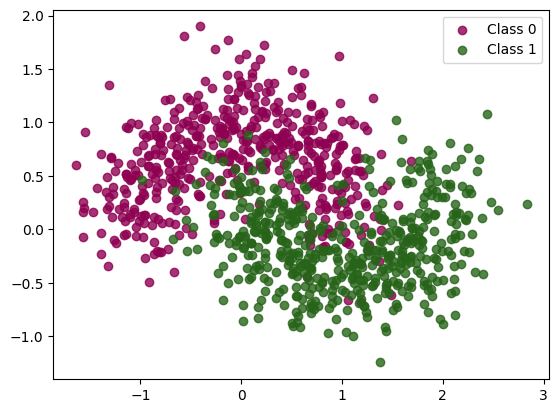

In [3]:
X, Y = make_moons(noise=noise, n_samples=1000)

for i in range(2):
    plt.scatter(
        X[Y == i, 0], 
        X[Y == i, 1], 
        color=cmap(float(i)), 
        label=f"Class {i}", 
        alpha=.8
    )
plt.legend()
plt.show()

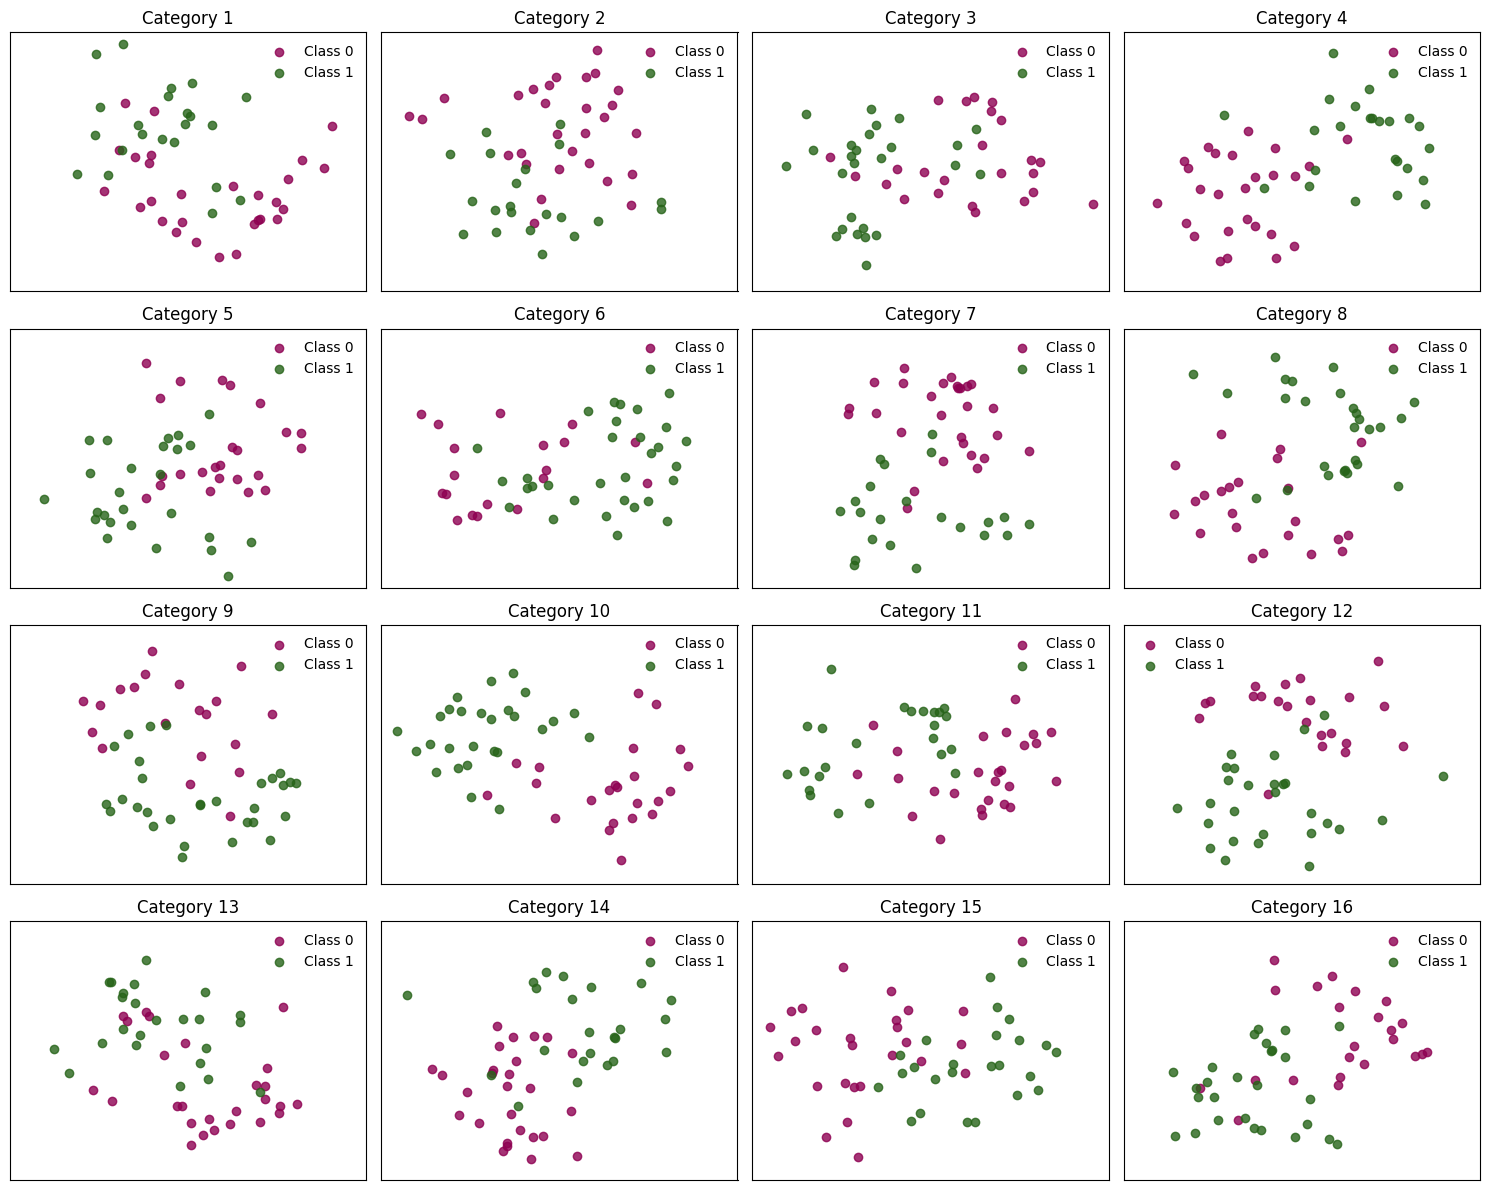

In [4]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])
    X = X.dot(R)
    return np.asarray(X)

np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=noise, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

fig, axs = plt.subplots(
    figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True
)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    for c in range(2):
        ax.scatter(
            X[Y == c, 0], 
            X[Y == c, 1], 
            color=cmap(float(c)), 
            label=f"Class {c}", 
            alpha=.8
        )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(frameon=False)
    ax.set(title=f"Category {i + 1}")

grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)
plt.tight_layout()
plt.show()

### Hierarchical model

In [5]:
@eqx.filter_vmap
def make_ensemble(key):
    # Create an ensemble of models
    net = eqx.nn.MLP(
        in_size=data_dim, 
        out_size=1, 
        width_size=hidden_layer_width, 
        depth=n_hidden_layers, 
        key=key
    )
    return net


@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_ensemble(ensemble, x):
    # Evaluate each member of the ensemble on the same data
    o = ensemble(x)
    return o.mean()


def apply_ensemble(ensemble, D):
    # Apply ensemble to multiple datapoints (batch)
    ensemble_fn = partial(evaluate_ensemble, ensemble)
    preds = jax.vmap(jax.vmap(ensemble_fn, in_axes=0), in_axes=1)(D)
    return preds


def evaluate_per_ensemble(model, x):
    return jax.vmap(model)(x)


def apply_ensemble(ensemble, D):
    ensemble_fn = partial(evaluate_ensemble, ensemble)
    preds = eqx.filter_vmap(evaluate_per_ensemble)(ensemble, D)
    return preds


key = jr.PRNGKey(0)

hnn = make_ensemble(jr.split(key, n_groups))
evaluate_ensemble(hnn, jnp.ones((data_dim,))).shape

(18,)

In [6]:
class NonCentredLinear(eqx.Module):
    mu: jax.Array
    eps: jax.Array
    std: jax.Array

    def __init__(self, in_size, out_size, n_groups, *, key):
        self.mu = jr.normal(key, (in_size, out_size))
        self.eps = jr.normal(key, (n_groups, in_size, out_size))
        self.std = jnp.ones((1,))

    def __call__(self, x):
        w = self.mu + self.std * self.eps
        return x @ w


class HNN(eqx.Module):
    layers: Tuple[NonCentredLinear]
    out: eqx.nn.Linear

    def __init__(self, layer_width, n_layers, n_groups, *, key):
        dims = [data_dim] + [layer_width] * n_layers
        layers = []
        for n, (_in, _out) in enumerate(zip(dims[:-1], dims[1:])):
            l = NonCentredLinear(
                _in, _out, n_groups, key=jr.fold_in(key, n)
            )
            layers += [l]
        self.layers = tuple(layers)
        self.out = eqx.nn.Linear(layer_width, 1, key=key)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            x = jax.nn.tanh(x)
        # Vmap over groups and samples
        o = jax.vmap(jax.vmap(self.out))(x)
        return o

In [7]:
def get_init_apply_fns(model):
    params, static = eqx.partition(model, eqx.is_inexact_array)

    def init_fn():
        return params

    def apply_fn(_params, x):
        model = eqx.combine(_params, static)
        return model(x)

    return init_fn, apply_fn

hnn = HNN(
    hidden_layer_width, n_hidden_layers, n_groups, key=key
)

init_fn, apply_fn = get_init_apply_fns(hnn)

params = init_fn()
apply_fn(params, jnp.ones((1, 2))).shape

(18, 1, 1)

### Sample utils

In [8]:
def inference_loop(key, step_fn, initial_state, num_samples):
    def one_step(state, key):
        state, _ = step_fn(key, state)
        return state, state

    keys = jr.split(key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

In [9]:
def get_predictions(model, samples, X, key):
    vectorized_apply = jax.vmap(apply_fn, in_axes=(0, None), out_axes=0)
    z = vectorized_apply(samples, X)
    predictions = tfd.Bernoulli(logits=z).sample(seed=key)
    return predictions.squeeze(-1)

In [10]:
def get_mean_predictions(predictions, threshold=0.5):
    # Compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

### Fitting

In [11]:
def fit_and_eval(
    key,
    initial_position, # Passed from `init_fn` of init/apply function conversion of Equinox NN
    model,
    logdensity_fn,
    X_train,
    Y_train,
    X_test,
    grid,
    num_warmup=1000,
    num_samples=500
):
    (
        warmup_key,
        inference_key,
        train_key,
        test_key,
        grid_key,
    ) = jr.split(key, 5)

    # Initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model)

    # Warm up
    adapt = blackjax.window_adaptation(blackjax.nuts, logprob)
    (final_state, params), _ = adapt.run(warmup_key, initial_position, num_warmup)
    step_fn = blackjax.nuts(logprob, **params).step

    # Inference
    states = inference_loop(inference_key, step_fn, final_state, num_samples)
    samples = states.position

    # Evaluation
    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

In [12]:
def logprior_fn(params):
    normal = tfd.Normal(0., 1.)
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(normal.log_prob(flat_params))


def logprior_fn_of_hnn(params, model):
    """ p(w) where w is NN(X; w) """
    lp = 0.
    half_normal = tfd.HalfNormal(1.)
    normal = tfd.Normal(0., 1.)
    for l in params.layers:
        lp += normal.log_prob(l.mu).sum()
        lp += normal.log_prob(l.eps).sum()
        lp += half_normal.log_prob(l.std).sum()
    lp += logprior_fn(params.out)
    return lp


def loglikelihood_fn(params, X, Y, model):
    """ p(Y|Y_=NN(X; w)) """
    logits = jnp.ravel(apply_fn(params, X))
    return jnp.sum(tfd.Bernoulli(logits).log_prob(jnp.ravel(Y)))


def logdensity_fn_of_hnn(params, X, Y, model):
    return logprior_fn_of_hnn(params, model) + loglikelihood_fn(params, X, Y, model)

In [13]:
key, inference_key = jr.split(key)

(
    Ys_hierarchical_pred_train, 
    Ys_hierarchical_pred_test, 
    ppc_grid
) = fit_and_eval(
    inference_key,
    params,
    hnn,
    logdensity_fn_of_hnn,
    Xs_train,
    Ys_train,
    Xs_test,
    grid_3d,
    num_warmup=num_warmup,
    num_samples=num_samples
)

In [14]:
print(
    "Train accuracy = {:.2f}%".format(
        100 * jnp.mean(Ys_hierarchical_pred_train == Ys_train)
    )
)

Train accuracy = 91.78%


In [15]:
print(
    "Test accuracy = {:.2f}%".format(
        100 * jnp.mean(Ys_hierarchical_pred_test == Ys_test)
    )
)

Test accuracy = 89.00%


In [16]:
def plot_decision_surfaces_hierarchical(nrows=2, ncols=2):
    fig, axes = plt.subplots(
        figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True
    )

    for i, (X, Y_pred, Y_true, ax) in enumerate(
        zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axes.flatten())
    ):
        ax.contourf(
            grid[:, 0].reshape((100, 100)),
            grid[:, 1].reshape((100, 100)),
            ppc_grid[:, i, :].mean(axis=0).reshape(100, 100),
            cmap=cmap,
            zorder=0
        )
        for i in range(2):
            ax.scatter(
                X[Y_true == i, 0], 
                X[Y_true == i, 1], 
                color="w", 
                alpha=.8, 
                s=20., 
                zorder=1
            )
            ax.scatter(
                X[Y_true == i, 0], 
                X[Y_true == i, 1], 
                color=cmap(float(i)), 
                label=f"Class {i}", 
                alpha=.8, 
                s=10., 
                zorder=2
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(frameon=False)

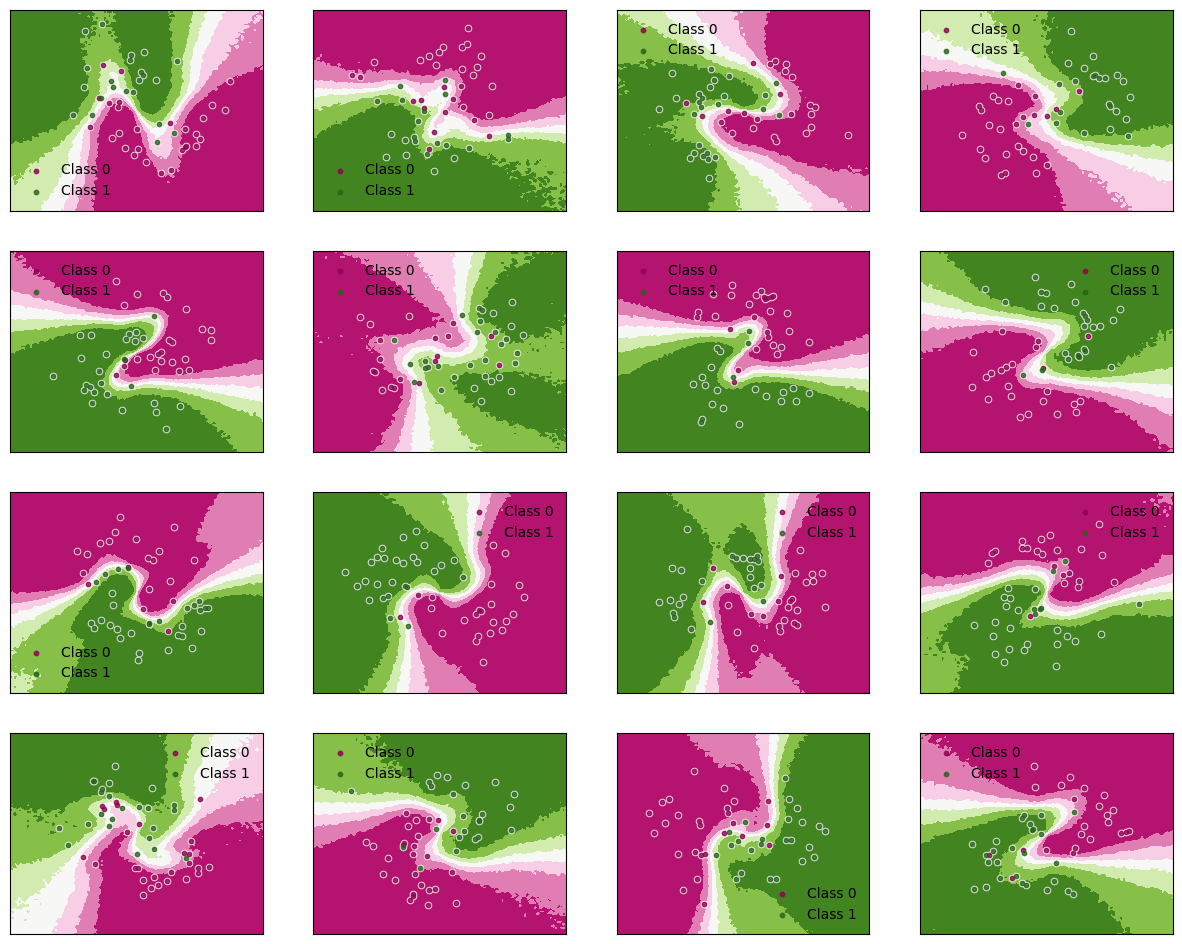

In [23]:
plot_decision_surfaces_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)
plt.savefig("figs/hbnn_decision_boundaries.png", bbox_inches="tight")
plt.show()